# RQ2 - EEG

## Import libraries

In [1]:
import mne
import numpy as np
import scipy.signal as signal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simps
from tqdm.notebook import tqdm
import os

## Create folder to save results

In [2]:
# create folder RQ2 if not exist
if not os.path.exists('./data/RQ2'):
    os.makedirs('./data/RQ2')

## Load data with the participant Algorithm EEG mapping

In [3]:
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_filtered = df_skill[["Participant", "Algorithm", "SkillScore", "EEG", "CrossEEG"]]
df_skill = df_skill[["Participant", "SkillScore"]]
df_skill = df_skill.drop_duplicates()
df_filtered

,Participant,Algorithm,SkillScore,EEG,CrossEEG
0,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecross...
1,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...,./data/filteredData/Participant01/SiebDesErato...
2,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...,./data/filteredData/Participant01/IsAnagramcro...
3,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...,./data/filteredData/Participant01/RemoveDouble...
4,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...,./data/filteredData/Participant01/BinToDecimal...
...,...,...,...,...,...
1067,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...,./data/filteredData/Participant71/DumpSortingc...
1068,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...,./data/filteredData/Participant71/BinomialCoef...
1069,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...,./data/filteredData/Participant71/IsAnagramcro...
1070,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...,./data/filteredData/Participant71/ArrayAverage...


## Helper methods for performing PSD and bandpower calculations

In [4]:
def get_spectrum(data, sampling_rate, method='welch', decibel=False, resolution='auto'):
    """
    Calculate amplitude or power spectrum

    data: Should be of shape (n_channels, n_samples)
    sampling_rate: Sampling rate... (float)
    method:
        * welch for power spectrum using Welch's method (recommended)
        * ft for simple Fourier transform (amplitude spectrum)
        * ps for power spectrum using a simple fourier transform
    decibel: Convert spectrum to decibel (bool)
    """

    axis = -1

    n_channels, n_samples = data.shape

    if resolution == 'auto':
        n_frequencies = n_samples
    elif isinstance(resolution, (int, float)):
        n_frequencies = np.round(sampling_rate / resolution).astype('int')
    else:
        raise ValueError('\'{}\''.format(resolution))

    # Spectrum
    if method in ['ft', 'ps']:
        # Using FFT
        # Get (complex) spectrum
        spec = np.fft.fft(data, n=n_frequencies, axis=axis)
        freq = np.fft.fftfreq(n_frequencies) * sampling_rate

        # Convert to real positive-sided spectrum
        spec = np.abs(spec)
        nyquist = 0.5 * sampling_rate
        is_positive = np.logical_or(np.logical_and(freq >= 0, freq <= nyquist), freq == -nyquist)
        n_pos = np.sum(is_positive)
        is_positive = np.repeat(is_positive[np.newaxis], n_channels, axis=0)
        spec = np.reshape(spec[is_positive], (n_channels, n_pos))
        freq = np.abs(freq[is_positive])
        is_double = np.logical_and(freq > 0, freq < nyquist)
        is_double = np.repeat(is_double[np.newaxis], n_channels, axis=0)
        spec[is_double] = 2 * spec[is_double]

        if method in ['ps']:
            # Get power spectral density
            spec = (1 / (sampling_rate * n_frequencies)) * spec ** 2

            # Convert to decibel if required
            if decibel:
                spec = _to_decibel(spec)
    elif method in ['welch', 'welch_db']:
        # Using Welch method
        freq, spec = signal.welch(data, sampling_rate, nperseg=n_frequencies, detrend='constant', axis=axis)

        # Convert to decibel if required
        if decibel:
            spec = _to_decibel(spec)
    else:
        raise RuntimeError('Unknown method \'{}\''.format(method))

    return spec, freq


def bandpower(spec, freq, freqband, relative=False):
    """
    Get band power within specified frequency band
    Alternatively: https://raphaelvallat.com/bandpower.html
    """

    spec = np.asarray(spec)
    freq = np.asarray(freq)
    freqband = np.asarray(freqband)

    if spec.ndim != 1:
        raise ValueError('Input \'spec\' bad: {}'.format(spec.shape))

    if freqband.ndim != 1 and freqband.shape[-1] != 2:
        raise ValueError('Input \'freqband\' bad: {}'.format(freqband.shape))

    # Frequency resolution
    step_freq = freq[1] - freq[0]

    # Find closest indices of band in frequency vector
    is_in_freqband = np.logical_and(freq >= np.min(freqband), freq <= np.max(freqband))

    # Integral approximation of the spectrum using Simpson's rule
    bp = simps(spec[is_in_freqband], dx=step_freq)

    if relative:
        bp = bp / simps(spec, dx=step_freq)

    return bp


def _to_decibel(spec):
    return 10 * np.log10(spec)


def get_mental_work_load(eeg_path, sampling_rate=500):
    # read in eeg file
    eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

    # get raw channel data and do mean average referencing
    eeg_data_raw = eeg_data.get_data()
    eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

    # extract channel names of eeg_data
    channel_names = list(eeg_data.to_data_frame().columns[1:])

    # create mock events for cutting eeg data (number, len, id)
    # events are set every 50 entry to move the window 0.1 seconds every time
    events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

    # create temporal eeg raw for cutting data into epochs
    tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

    # create epochs which have a 3 second window and operate on event id 1
    epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True,
                               verbose='ERROR')

    # calculate Mental Workload for each window
    mwl_array = []

    for epoch_data_raw in epochs:
        # perform power spectrum analysis on eeg data
        spectrum, frequency = get_spectrum(epoch_data_raw, sampling_rate, method='welch', decibel=False,
                                           resolution='auto')

        # calculate Mental Workload by dividing the power spectrum of the relative theta band power divided by relative alpha band power
        # on channel Fz for theta and Pc for alpha
        theata_power = bandpower(spectrum[channel_names.index("Fz"), :], frequency, [4.0, 8.0], relative=True)
        alpha_power = bandpower(spectrum[channel_names.index("Pz"), :], frequency, [8.0, 13.0], relative=True)
        MWL = theata_power / alpha_power

        # append Mental Workload to array
        mwl_array.append(MWL)
    return mwl_array


def get_brainwaves(eeg_path, sampling_rate=500):
    # read in eeg file
    eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

    # get raw channel data and do mean average referencing
    eeg_data_raw = eeg_data.get_data()
    eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

    # extract channel names of eeg_data
    channel_names = list(eeg_data.to_data_frame().columns[1:])

    # create mock events for cutting eeg data (number, len, id)
    events = np.array([(0, 0, 1)])

    # create temporal eeg raw for cutting data into epochs
    tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

    # calc duration
    duration = (eeg_data_ref.shape[-1] - 1) / sampling_rate

    # create epochs which have a duration second window and operate on event id 1
    epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=duration, baseline=None, preload=True,
                               verbose='ERROR')

    alpha = np.array([])
    beta = np.array([])
    gamma = np.array([])
    theta = np.array([])

    for epoch_data_raw in epochs:
        # perform power spectrum analysis on eeg data
        spectrum, frequency = get_spectrum(epoch_data_raw, sampling_rate, method='welch', decibel=False,
                                           resolution='auto')

        alpha_current = np.array([])
        beta_current = np.array([])
        gamma_current = np.array([])
        theta_current = np.array([])

        for channel in channel_names:
            alpha_current = np.append(alpha_current,
                                      bandpower(spectrum[channel_names.index(channel), :], frequency, [8.0, 13.0],
                                                relative=True))
            beta_current = np.append(beta_current,
                                     bandpower(spectrum[channel_names.index(channel), :], frequency, [13.0, 30.0],
                                               relative=True))
            gamma_current = np.append(gamma_current,
                                      bandpower(spectrum[channel_names.index(channel), :], frequency, [30.0, 50.0],
                                                relative=True))
            theta_current = np.append(theta_current,
                                      bandpower(spectrum[channel_names.index(channel), :], frequency, [4.0, 8.0],
                                                relative=True))

        alpha = np.append(alpha, alpha_current)
        beta = np.append(beta, beta_current)
        gamma = np.append(gamma, gamma_current)
        theta = np.append(theta, theta_current)
    return alpha, beta, gamma, theta

## Calculate Mental Workload for each participant for each algorithm

In [5]:
# sampling rate of the EEG data
sampling_rate = 500

# create Mental Workload column
df_filtered["MentalWorkLoad"] = [np.array([]) for i in range(len(df_filtered))]

# iterate over each row anc calculate Mental Workload for the task
for idx in tqdm(range(len(df_filtered))):
    algorithm = df_filtered.iloc[idx]["Algorithm"]
    participant = df_filtered.iloc[idx]["Participant"]
    skill_score = df_filtered.iloc[idx]["SkillScore"]
    eeg_path = df_filtered.iloc[idx]["EEG"]
    cross_eeg_path = df_filtered.iloc[idx]["CrossEEG"]

    # calculate Mental Workload for each algorithm
    mwl_task = get_mental_work_load(eeg_path)

    # calculate Mental Workload for the cross task as baseline
    mwl_base_line = get_mental_work_load(cross_eeg_path)
    base_line_expected_value = np.mean(mwl_base_line)
    base_line_variance = np.var(mwl_base_line)

    # calculate Mental Workload z score
    mwl_z_score = (mwl_task - base_line_expected_value) / base_line_variance

    # append Mental Workload to the current row
    df_filtered.at[idx, "MentalWorkLoad"] = mwl_z_score
df_filtered

  0%|          | 0/1072 [00:00<?, ?it/s]

,Participant,Algorithm,SkillScore,EEG,CrossEEG,MentalWorkLoad
0,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecross...,"[-0.13892258727108667, -0.43873106314970606, -..."
1,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...,./data/filteredData/Participant01/SiebDesErato...,"[10.383266760002432, 10.940827582840825, 11.67..."
2,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...,./data/filteredData/Participant01/IsAnagramcro...,"[11.264726753330484, 14.295609056672376, 18.26..."
3,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...,./data/filteredData/Participant01/RemoveDouble...,"[4.590957719937249, 2.410952883543482, 0.98448..."
4,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...,./data/filteredData/Participant01/BinToDecimal...,"[-0.33471300665826237, -1.0892325347817868, -1..."
...,...,...,...,...,...,...
1067,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...,./data/filteredData/Participant71/DumpSortingc...,"[2.337986408309993, 2.39293503110521, 2.205377..."
1068,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...,./data/filteredData/Participant71/BinomialCoef...,"[-1.249218045940767, -1.1235093191948313, -0.9..."
1069,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...,./data/filteredData/Participant71/IsAnagramcro...,"[-0.01885877411707073, -0.04772466143860257, -..."
1070,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...,./data/filteredData/Participant71/ArrayAverage...,"[-2.0509862551350113, -1.8860939816161022, -1...."


In [6]:
# save the filtered dataframe to csv
df_tmp = df_filtered.copy()
df_save = df_tmp.copy()
df_tmp["MentalWorkLoad"] = df_tmp["MentalWorkLoad"].apply(lambda series: str(list(series)))
df_tmp.to_csv("./data/RQ2/MentalWorkLoadRaw.csv", sep=";", index=False)

In [7]:
def string_to_list_string(data):
    data = data.replace(' ', ',')
    data = data.replace('\n', ',')
    data = ','.join([element for element in data.split(",") if len(element) > 0])
    if data[1] == ",":
        data = "[" + data[2:]
    return data


df_filtered = pd.read_csv("./data/RQ2/MentalWorkLoadRaw.csv", sep=";")
df_filtered["MentalWorkLoad"] = df_filtered["MentalWorkLoad"].apply(string_to_list_string)
df_filtered["MentalWorkLoad"] = df_filtered["MentalWorkLoad"].apply(lambda x: np.array(eval(x)))

# Calculate metrics and stats for MWL

In [8]:
# stats per algorithm per participant
filter = df_filtered.filter(
    ["MWLLength", "MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope",
     "PeakToPeak", "MWL_max_slope"])
df_filtered = df_filtered.drop(filter, axis=1)

df_filtered.insert(loc=0, column="MWLLength", value=df_filtered["MentalWorkLoad"].apply(len))
df_filtered.insert(loc=0, column="MWLMean", value=df_filtered["MentalWorkLoad"].apply(np.mean))
df_filtered.insert(loc=0, column="MWLMedian", value=df_filtered["MentalWorkLoad"].apply(np.median))
df_filtered.insert(loc=0, column="MWLStd", value=df_filtered["MentalWorkLoad"].apply(np.std))
df_filtered.insert(loc=0, column="MWLMin", value=df_filtered["MentalWorkLoad"].apply(np.min))
df_filtered.insert(loc=0, column="MWLMax", value=df_filtered["MentalWorkLoad"].apply(np.max))
df_filtered.insert(loc=0, column="PeakToPeak", value=df_filtered["MentalWorkLoad"].apply(np.ptp))
df_filtered.insert(loc=0, column="MWL_max_slope",
                   value=df_filtered["MentalWorkLoad"].apply(lambda x: np.amax(np.diff(x))))
df_filtered.insert(loc=0, column="MWL_average_slope",
                   value=df_filtered["MentalWorkLoad"].apply(lambda x: np.mean(np.diff(x))))
df_filtered.insert(loc=0, column="MWL_total_slope",
                   value=df_filtered["MentalWorkLoad"].apply(lambda x: np.sum(np.diff(x))))

df_filtered

,MWL_total_slope,MWL_average_slope,MWL_max_slope,PeakToPeak,MWLMax,MWLMin,MWLStd,MWLMedian,MWLMean,MWLLength,Participant,Algorithm,SkillScore,EEG,CrossEEG,MentalWorkLoad
0,1.022999,0.011000,1.386310,14.703984,13.301451,-1.402534,4.419172,1.364306,3.275135,94,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecross...,"[-0.13892258727108667, -0.43873106314970606, -..."
1,-4.549469,-0.003043,12.166329,98.975122,95.520112,-3.455010,12.395061,10.690036,13.580735,1496,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...,./data/filteredData/Participant01/SiebDesErato...,"[10.383266760002432, 10.940827582840825, 11.67..."
2,1.821815,0.001711,9.070214,79.188335,75.338228,-3.850107,13.076808,13.036157,16.445308,1066,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...,./data/filteredData/Participant01/IsAnagramcro...,"[11.264726753330484, 14.295609056672376, 18.26..."
3,11.616370,0.023048,7.546961,80.442853,78.904098,-1.538755,15.332822,23.532926,24.997320,505,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...,./data/filteredData/Participant01/RemoveDouble...,"[4.590957719937249, 2.410952883543482, 0.98448..."
4,-0.506064,-0.001079,2.983964,30.890963,27.805894,-3.085069,6.414601,3.800913,5.428213,470,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...,./data/filteredData/Participant01/BinToDecimal...,"[-0.33471300665826237, -1.0892325347817868, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,1.577254,0.001430,1.505314,14.298659,11.502140,-2.796519,2.470559,0.003212,0.523946,1104,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...,./data/filteredData/Participant71/DumpSortingc...,"[2.337986408309993, 2.39293503110521, 2.205377..."
1068,5.447107,0.011444,3.904314,32.166323,28.960164,-3.206159,5.425518,2.244195,3.521773,477,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...,./data/filteredData/Participant71/BinomialCoef...,"[-1.249218045940767, -1.1235093191948313, -0.9..."
1069,-0.109177,-0.000101,1.583998,10.604007,9.494406,-1.109601,1.443230,0.121333,0.547439,1080,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...,./data/filteredData/Participant71/IsAnagramcro...,"[-0.01885877411707073, -0.04772466143860257, -..."
1070,4.140973,0.078132,1.006144,4.862357,2.811370,-2.050986,1.371703,-0.047294,0.215103,54,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...,./data/filteredData/Participant71/ArrayAverage...,"[-2.0509862551350113, -1.8860939816161022, -1...."


In [9]:
df_filtered[["MWL_total_slope", "MWL_average_slope", "MWLMax", "MWLMin", "MWLStd", "MWLMedian", "MWLMean", "MWLLength",
             "Participant", "Algorithm", "SkillScore"]].to_csv("./data/RQ2/MentalWorkLoadStatsRaw.csv")

In [10]:
# stats per participant
df_mwl_participant = df_filtered.groupby(["Participant"]).agg({
    "MWLMean": "mean",
    "MWLMedian": "mean",
    "MWLStd": "mean",
    "MWLMin": "mean",
    "MWLMax": "mean",
    "PeakToPeak": "mean",
    "MWL_max_slope": "mean",
    "MWL_average_slope": "mean",
    "MWL_total_slope": "mean", })
df_mwl_participant = df_mwl_participant.reset_index()
df_mwl_participant["Participant"] = df_mwl_participant["Participant"].astype(int)
df_mwl_participant = pd.merge(df_mwl_participant, df_skill, on="Participant")

# save to csv
df_mwl_participant.to_csv("./data/RQ2/MentalWorkLoadStats.csv")

df_mwl_participant

,Participant,MWLMean,MWLMedian,MWLStd,MWLMin,MWLMax,PeakToPeak,MWL_max_slope,MWL_average_slope,MWL_total_slope,SkillScore
0,1,19.280904,15.211522,15.141822,-0.297835,76.060321,76.358156,10.023145,0.061008,2.095644,0.331385
1,2,0.128938,-0.014658,0.662554,-0.771885,2.705350,3.477236,0.422110,0.000465,0.296993,0.379187
2,3,3.251436,2.127598,4.956118,-3.723415,22.944076,26.667490,3.388646,0.001173,0.650041,0.311264
3,4,0.052015,-0.149009,0.805805,-0.952525,3.504082,4.456607,0.532811,-0.000166,-0.053856,0.424727
4,5,2.998213,2.412264,2.978330,-1.289283,14.153385,15.442669,1.724063,-0.004385,-1.753477,0.313031
5,6,-0.495755,-0.876417,1.824580,-3.241186,7.330267,10.571454,1.260579,0.000451,-0.005527,0.315932
6,7,3.040418,2.209245,3.707046,-2.081989,19.124410,21.206399,2.363703,-0.005175,-2.834002,0.420873
7,10,2.325290,1.831886,2.639406,-1.382621,11.823724,13.206345,1.626860,0.004227,0.044020,0.350392
8,11,1.443629,0.918390,2.454376,-2.075666,11.740733,13.816399,1.707749,-0.003261,0.017532,0.178206
9,12,0.997825,0.559587,2.100690,-2.152843,10.046974,12.199817,1.314262,0.001850,0.722263,0.309233


In [11]:
df_corr = df_mwl_participant.corrwith(df_mwl_participant["SkillScore"])
df_tmp = pd.DataFrame(df_corr, columns=["Correlation with SkillScore"])
# save df_tmp to csv
df_tmp.to_csv("./data/RQ2/MentalWorkLoadCorrelation.csv")
df_corr

Participant         -0.049840
MWLMean             -0.140466
MWLMedian           -0.125912
MWLStd              -0.197186
MWLMin               0.273804
MWLMax              -0.226437
PeakToPeak          -0.233771
MWL_max_slope       -0.227163
MWL_average_slope   -0.058538
MWL_total_slope     -0.046090
SkillScore           1.000000
dtype: float64

## Plotting of Mental Workload stats

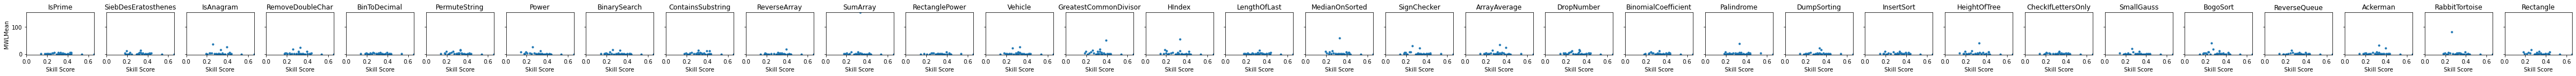

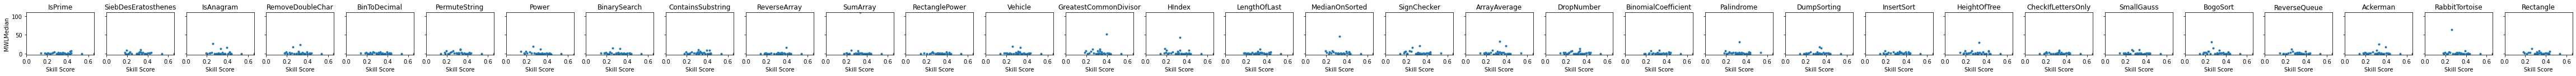

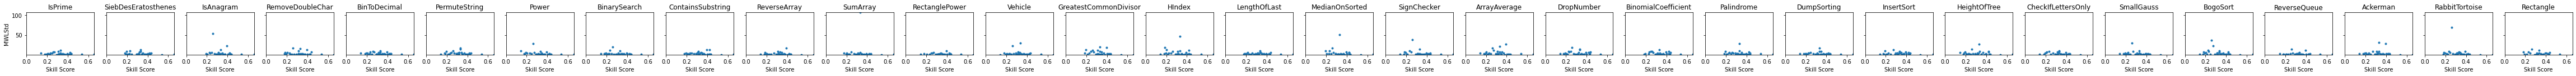

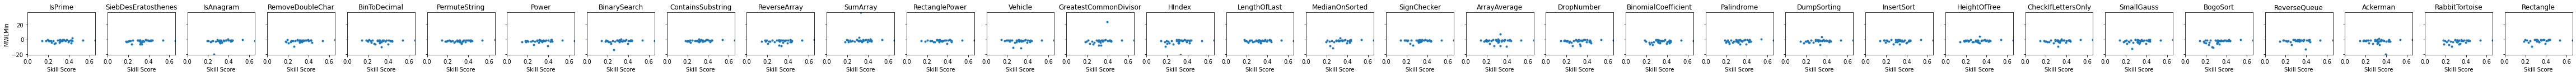

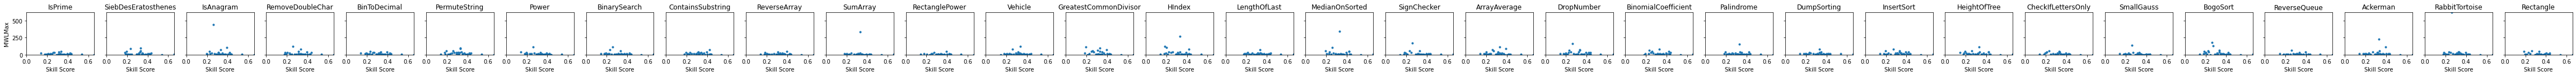

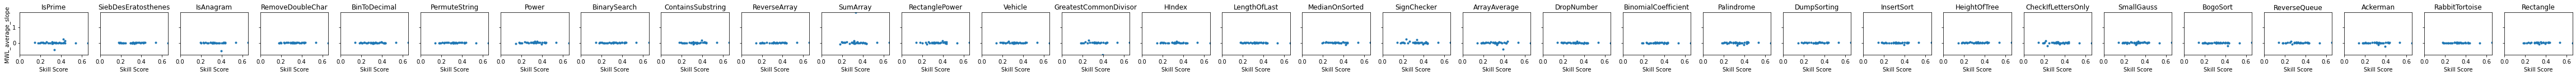

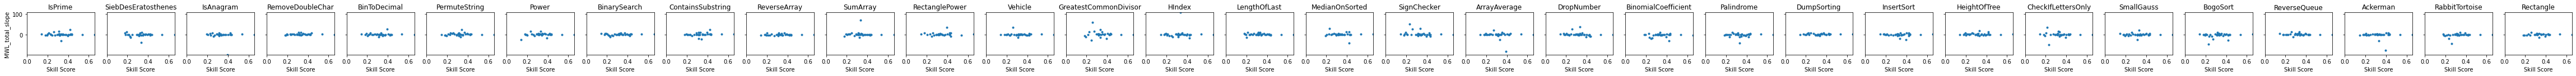

In [12]:
# create folder if not exists
if not os.path.exists("./data/RQ2/plots/MentalWorkLoadStats"):
    os.makedirs("./data/RQ2/plots/MentalWorkLoadStats")

# plot some results
number_of_algorithms = len(df_filtered["Algorithm"].unique())
sample_number = number_of_algorithms


def scatter_plot_metric_skill_score(df, sample_number, column, name=None):
    if name is None:
        name = column
    fig, ax = plt.subplots(1, sample_number, figsize=(sample_number * 2, 2))

    for idx, algorithm in enumerate(df["Algorithm"].unique()[:sample_number]):
        df_filtered_algorithm = df[df["Algorithm"] == algorithm]
        ax[idx].plot(df_filtered_algorithm["SkillScore"], df_filtered_algorithm[column], ".")
        ax[idx].set_title(algorithm)
        ax[idx].set_ylabel(name)
        ax[idx].set_xlabel("Skill Score")
        if idx != 0:
            ax[idx].set(ylabel=None)
            ax[idx].set_yticklabels([])
        ax[idx].set_ylim([df_filtered[column].min(), df_filtered[column].max()])
        ax[idx].set_xlim([0, df_filtered["SkillScore"].max()])
    return fig, ax


for column in ["MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"]:
    fig, ax = scatter_plot_metric_skill_score(df_filtered, sample_number, column)
    fig.tight_layout()
    plt.savefig("./data/RQ2/plots/MentalWorkLoadStats/" + column + ".pdf")
    plt.show()


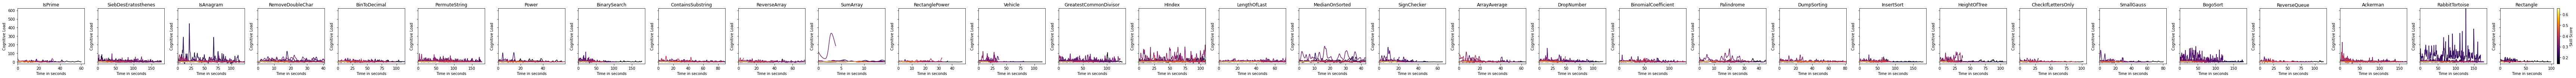

In [13]:
# create folder if not exists
if not os.path.exists("./data/RQ2/plots/MentalWorkLoadPerTime"):
    os.makedirs("./data/RQ2/plots/MentalWorkLoadPerTime")


# plot course of mental workload per algorithm
def course_plot_mwl_color_by_skill_score(df, ax, algorithm=None, min=None, max=None):
    df_algorithm = df[df["Algorithm"] == algorithm]
    if algorithm is None:
        df_algorithm = df
        algorithm = "All"
    df_algorithm = df_algorithm.sort_values(by=["SkillScore"]).reset_index(drop=True)
    min_skill_score = df_algorithm["SkillScore"].min()
    max_skill_score = df_algorithm["SkillScore"].max()
    cm = plt.get_cmap("inferno")

    for idx, row in df_algorithm.iterrows():
        time = np.linspace(0, len(row["MentalWorkLoad"]), len(row["MentalWorkLoad"]))
        time = time / 10
        color = cm((row["SkillScore"] - min_skill_score) / (max_skill_score - min_skill_score))
        ax.plot(time, row["MentalWorkLoad"], color=color)
        ax.set_xlabel("Time in seconds")
        ax.set_ylabel("Cognitive Load")
        ax.set_title(algorithm)
        ax.set_xlim(0, )
        ax.set_ylim(min_mwl, max_mwl)


fig, ax = plt.subplots(1, sample_number, figsize=(sample_number * 3, 3))
min_mwl = min([min(value) for value in df_filtered["MentalWorkLoad"]])
max_mwl = max([max(value) for value in df_filtered["MentalWorkLoad"]])
min_mwl = np.floor(min_mwl)
max_mwl = np.ceil(max_mwl)

scalar_mapable = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=df_filtered["SkillScore"].min(), vmax=df_filtered["SkillScore"].max()), cmap="inferno")
cbar = plt.colorbar(scalar_mapable, ax=ax[-1], orientation="vertical")
cbar.set_label("Skill Score")
for idx, algorithm in enumerate(df_filtered["Algorithm"].unique()):
    course_plot_mwl_color_by_skill_score(df_filtered, ax[idx], algorithm, min_mwl, max_mwl)
    if idx != 0:
        ax[idx].set_yticklabels([])
# add colorbar
fig.tight_layout()
plt.savefig("./data/RQ2/plots/MentalWorkLoadPerTime/MWL_per_algorithm.pdf")
plt.show()

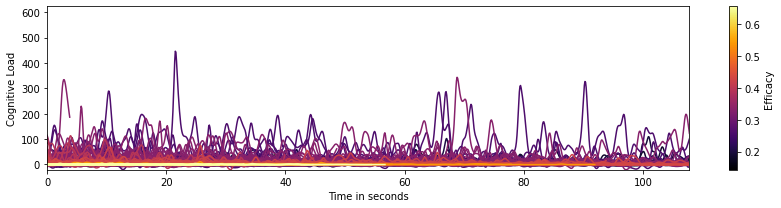

In [14]:
fig, ax = plt.subplots(figsize=(12, 3))
scalar_mapable = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=df_filtered["SkillScore"].min(), vmax=df_filtered["SkillScore"].max()), cmap="inferno")
cbar = plt.colorbar(scalar_mapable, ax=ax, orientation="vertical")
cbar.set_label("Efficacy")
course_plot_mwl_color_by_skill_score(df_filtered, ax)
plt.title("")
plt.tight_layout()
plt.savefig("./data/RQ2/plots/MentalWorkLoadPerTime/MWL_total.pdf")
plt.show()

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\847166107.py:26: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(min_mwl, max_mwl)


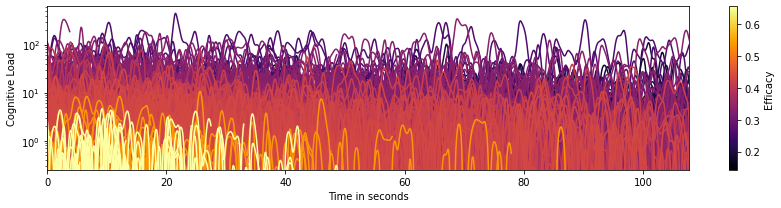

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))
scalar_mapable = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=df_filtered["SkillScore"].min(), vmax=df_filtered["SkillScore"].max()), cmap="inferno")
cbar = plt.colorbar(scalar_mapable, ax=ax, orientation="vertical")
cbar.set_label("Efficacy")
plt.yscale("log")
course_plot_mwl_color_by_skill_score(df_filtered, ax)
plt.ylim(2**-2)
plt.title("")
plt.tight_layout()
plt.savefig("./data/RQ2/plots/MentalWorkLoadPerTime/MWL_total_log_2.pdf")
plt.show()

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\1232834995.py:1: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\847166107.py:26: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(min_mwl, max_mwl)


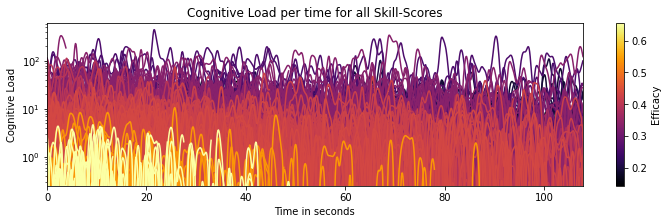

In [16]:
from scipy.ndimage.filters import convolve

df_tmp = df_filtered.copy()
for idx, row in df_tmp.iterrows():
    mwl = row["MentalWorkLoad"]
    mwl = convolve(mwl, weights=np.ones(sampling_rate * 30))
    df_tmp.at[idx, "MentalWorkLoad"] = mwl

fig, ax = plt.subplots(figsize=(12, 3))
scalar_mapable = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=df_filtered["SkillScore"].min(), vmax=df_filtered["SkillScore"].max()), cmap="inferno")
cbar = plt.colorbar(scalar_mapable, ax=ax, orientation="vertical")
cbar.set_label("Efficacy")
plt.yscale("log")
course_plot_mwl_color_by_skill_score(df_filtered, ax)
plt.ylim(2**-2)
plt.title("Cognitive Load per time for all Skill-Scores")
plt.savefig("./data/RQ2/plots/MentalWorkLoadPerTime/MWL_total_smooth_30s.pdf")
plt.show()

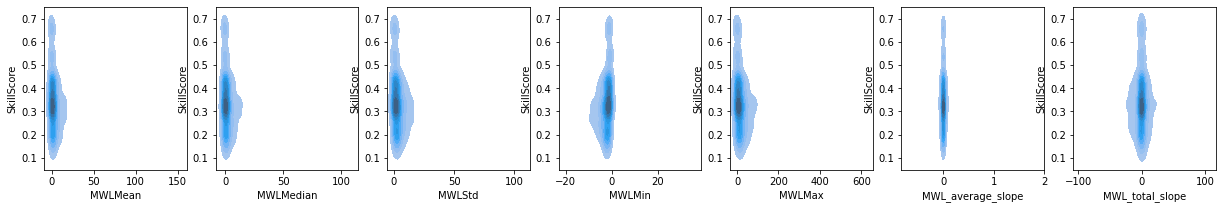

In [17]:
import seaborn as sns

# kdeplot of mental workload vs skill score
columns = ["MWLMean", "MWLMedian", "MWLStd", "MWLMin", "MWLMax", "MWL_average_slope", "MWL_total_slope"]
fig, ax = plt.subplots(1, len(columns), figsize=(len(columns) * 3, 3))
for idx, column in enumerate(columns):
    sns.kdeplot(df_filtered[column], y=df_filtered["SkillScore"], ax=ax[idx], label=column, shade=True)
plt.savefig("./data/RQ2/plots/MentalWorkLoadStats/kde_mwl.pdf")
plt.show()

## Generate Topographical Plots

In [18]:
if not os.path.exists("./data/RQ2/plots/TopographicalPlots"):
    os.makedirs("./data/RQ2/plots/TopographicalPlots")

# sampling rate of the EEG data
sampling_rate = 500

# read in montage and calculate the electrode positions
montage_path = "./data/EEG/AC-64.bvef"
montage = mne.channels.read_custom_montage(montage_path, head_size=0.085)

# get algorithm names and participants grouping
algo_names = df_filtered["Algorithm"].unique()
algo_names.sort()
participants = df_filtered["Participant"].unique()

# create Mental Workload column
df_filtered["MentalWorkLoad"] = [np.array([]) for i in range(len(df_filtered))]

# iterate over each row anc calculate Mental Workload for the task
for participant in tqdm(participants, total=len(participants)):
    df_participant = df_filtered[df_filtered["Participant"] == participant]
    skill_score = df_participant.iloc[0]["SkillScore"]

    # create figure for total topographical plot of all algorithms
    fig = plt.figure(constrained_layout=True, figsize=(6, len(algo_names) * 3))
    fig.suptitle(f"Participant {participant} - Skill Score: {skill_score}")

    # create algo_names subfigures for topographical plots
    subfigures = fig.subfigures(nrows=len(algo_names), ncols=1)

    # get the eeg data for the participant and each algorithm
    for idx, algorithm in tqdm(enumerate(algo_names), total=len(algo_names)):
        df_algorithm = df_participant[df_participant["Algorithm"] == algorithm]

        # set the title of the subfigure
        subfigures[idx].suptitle(f"Topographical Plot for {algorithm}")

        # get the axis object
        ax = subfigures[idx].subplots(nrows=1, ncols=2)

        if len(df_algorithm) == 0:
            continue

        eeg_path = df_algorithm.iloc[0]["EEG"]

        # read in eeg file
        eeg_data = mne.io.read_raw_fif(eeg_path, preload=True, verbose='ERROR')

        # set montage
        eeg_data.set_montage(montage)

        # get raw channel data and do mean average referencing
        eeg_data_raw = eeg_data.get_data()
        eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

        # create mock events for cutting eeg data (number, len, id)
        # events are set every 50 entry to move the window 0.1 seconds every time
        events = np.array([(i, 0, 1) for i in range(0, eeg_data_ref.shape[-1], 50)])

        # create temporal eeg raw for cutting data into epochs
        tmp_raw = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')

        # create epochs which have a 3 second window and operate on event id 1
        epochs = mne.epochs.Epochs(tmp_raw, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True,
                                   verbose='ERROR')

        # get the corresponding algorithm index
        epochs.plot_psd_topomap(bands=[(4.0, 8.0, "theta"), (8.0, 12.0, "alpha")], axes=ax, show=False, cmap='jet',
                                verbose='ERROR')
    plt.savefig(f"./data/RQ2/plots/TopographicalPlots/Topo_Skill_{skill_score:.4f}_Participant_{participant}.pdf")
    plt.close()

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\jonas\AppData\Local\Temp\ipykernel_23156\3985345027.py:50: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  eeg_data.set_montage(montage)
C:\Users\j

## Lee Replication

In [ ]:
# glättung des eeg signals
# moving mean filter von einer sekunde
# topoplots for each participant
# topoplots per 1/3


# pro elektro alpha band power berechnen
# pro elektro beta band power berechnen
# pro elektro gamma band power berechnen
# pro elektro theta band power berechnen

# mean gebildet prop proband und corr für alle tasks

# lobes
# einteilung in f c p
# mean gebildet pro proband und corr für alle tasks


### Get Power Bands

In [184]:
# read in montage and calculate the electrode positions
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_eeg_data = df_skill[["Participant", "Algorithm", "SkillScore", "EEG", "CrossEEG"]]

# sampling rate of the EEG data
sampling_rate = 500

# create Mental Workload column
df_brain_waves = pd.DataFrame(columns=["Participant", "SkillScore", "Algorithm", "Alpha", "Beta", "Gamma", "Theta"])

# iterate over each row anc calculate Mental Workload for the task
for idx in tqdm(range(len(df_eeg_data))):
    participant = df_eeg_data.iloc[idx]["Participant"]
    skill_score = df_eeg_data.iloc[idx]["SkillScore"]
    algorithm = df_eeg_data.iloc[idx]["Algorithm"]
    eeg_path = df_eeg_data.iloc[idx]["EEG"]
    cross_eeg_path = df_eeg_data.iloc[idx]["CrossEEG"]

    alpha, beta, gamma, theta = get_brainwaves(eeg_path)
    alpha = alpha.reshape(64, 1)
    beta = beta.reshape(64, 1)
    gamma = gamma.reshape(64, 1)
    theta = theta.reshape(64, 1)
    df_brain_waves.loc[len(df_brain_waves)] = [participant, skill_score, algorithm, alpha, beta, gamma, theta]

# read in one example file
example_cross_file = df_eeg_data.iloc[0]["CrossEEG"]
# read in the cross file
cross_eeg_data = mne.io.read_raw_fif(example_cross_file, verbose='ERROR')
# get the channel names
channel_names = cross_eeg_data.ch_names

df_brain_waves_values = pd.DataFrame(
    columns=["Participant", "SkillScore", "Channel", "Alpha", "Beta", "Gamma", "Theta"])

for participant in tqdm(df_brain_waves["Participant"].unique(), total=len(df_brain_waves["Participant"].unique())):
    df_participant = df_brain_waves[df_brain_waves["Participant"] == participant]
    skill_score = df_participant["SkillScore"].unique()[0]

    merged_alpha = np.zeros(shape=(64, 0))
    merged_beta = np.zeros(shape=(64, 0))
    merged_gamma = np.zeros(shape=(64, 0))
    merged_theta = np.zeros(shape=(64, 0))

    for idx, row in df_participant.iterrows():
        alpha = row["Alpha"]
        beta = row["Beta"]
        gamma = row["Gamma"]
        theta = row["Theta"]

        merged_alpha = np.concatenate((merged_alpha, alpha), axis=1)
        merged_beta = np.concatenate((merged_beta, beta), axis=1)
        merged_gamma = np.concatenate((merged_gamma, gamma), axis=1)
        merged_theta = np.concatenate((merged_theta, theta), axis=1)

    for idx, channel in enumerate(channel_names):
        alpha_channeled = merged_alpha[idx, :]
        beta_channeled = merged_beta[idx, :]
        gamma_channeled = merged_gamma[idx, :]
        theta_channeled = merged_theta[idx, :]

        alpha_mean = np.mean(alpha_channeled)
        beta_mean = np.mean(beta_channeled)
        gamma_mean = np.mean(gamma_channeled)
        theta_mean = np.mean(theta_channeled)

        df_brain_waves_values.loc[len(df_brain_waves_values)] = [participant, skill_score, channel, alpha_mean,
                                                                 beta_mean, gamma_mean, theta_mean]

  0%|          | 0/1072 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [186]:
df_tmp = df_brain_waves_values.copy()
# classifiy lobe
df_tmp["lobe"] = "None"
df_tmp.loc[(df_tmp["Channel"].str.contains("F")) | (df_tmp["Channel"].str.contains("f")), "lobe"] = "frontal"
df_tmp.loc[(df_tmp["Channel"].str.contains("P")) | (df_tmp["Channel"].str.contains("p")), "lobe"] = "parietal"
df_tmp.loc[(df_tmp["Channel"].str.contains("C")) | (df_tmp["Channel"].str.contains("c")), "lobe"] = "occipital"
df_tmp = df_tmp[df_tmp["lobe"] != "None"]

# get the skill scores
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_skill = df_skill[["Participant", "SkillScore"]]
df_skill = df_skill.drop_duplicates()
quantile = df_skill["SkillScore"].quantile([0.33, 0.66])
lower = quantile[0.33]
upper = quantile[0.66]

# split the dataframe based on the skill score, lowest 33% and highest 33%
df_skill["class"] = "None"
df_skill.loc[df_skill["SkillScore"] < lower, "class"] = "low"
df_skill.loc[df_skill["SkillScore"] > upper, "class"] = "high"
df_skill = df_skill[df_skill["class"] != "None"]

df_class_bandpower = pd.DataFrame([], columns=["Class", "Lobe", "Band", "Mean"])
for lobe, letter in zip(["Frontal", "Central", "Parietal"], ["F", "C", "P"]):
    for band in ["Alpha", "Beta", "Gamma", "Theta"]:
        for skill_class in ["low", "high"]:
            # get the dataframe for the skill class
            participants_in_class = df_skill[df_skill["class"] == skill_class]["Participant"].unique()
            df_participants_in_class = df_tmp[df_tmp["Participant"].isin(participants_in_class)]

            # filter for channel
            df_participants_in_class = df_participants_in_class[
                (df_participants_in_class["Channel"].str.contains(letter)) & (
                            df_participants_in_class["Channel"].str.len() == 2)]

            # get the dataframe for the band
            df_band = df_participants_in_class[band]
            band_mean = df_band.mean()
            df_class_bandpower.loc[len(df_class_bandpower)] = [skill_class, lobe, band, band_mean]
df_class_bandpower

,Class,Lobe,Band,Mean
0,low,Frontal,Alpha,0.172218
1,high,Frontal,Alpha,0.143687
2,low,Frontal,Beta,0.147698
3,high,Frontal,Beta,0.152290
4,low,Frontal,Gamma,0.069892
5,high,Frontal,Gamma,0.077079
6,low,Frontal,Theta,0.279529
7,high,Frontal,Theta,0.288530
8,low,Central,Alpha,0.236296
9,high,Central,Alpha,0.177617


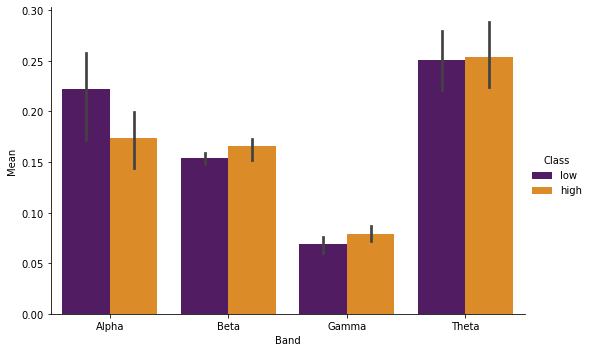

In [187]:
# plot bar graph for each band
import seaborn as sns
cm = sns.color_palette("inferno", 3)

palette ={"low": cm[0], "high": cm[2]}
ax = sns.catplot(x="Band", y="Mean", hue="Class", data=df_class_bandpower, kind="bar", height=5, aspect=1.5, palette=palette)
ax.set(xlabel="Band", ylabel="Mean")
plt.savefig(f"./data/RQ2/plots/band_power_per_group.pdf")
plt.show()

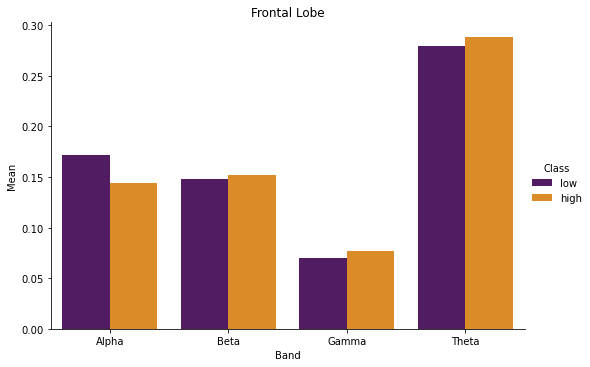

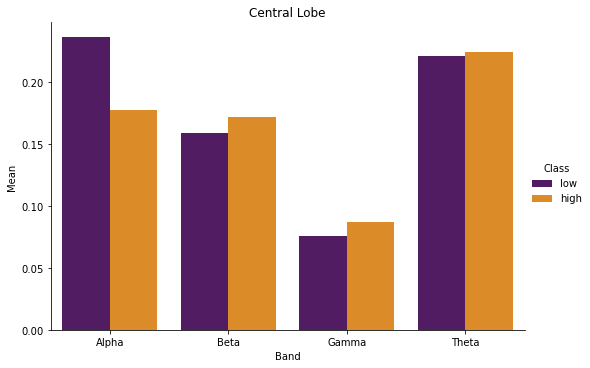

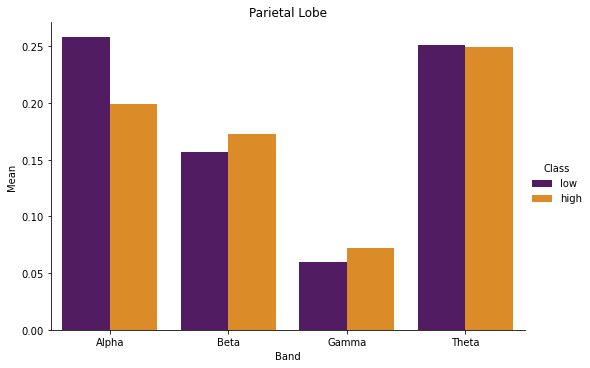

In [188]:
for lobe in ["Frontal", "Central", "Parietal"]:
    df_tmp = df_class_bandpower.copy()
    df_tmp = df_tmp[df_tmp["Lobe"] == lobe]
    ax = sns.catplot(x="Band", y="Mean", hue="Class", data=df_tmp, kind="bar", height=5, aspect=1.5, palette=palette)
    ax.set(xlabel="Band", ylabel="Mean")
    plt.title(f"{lobe} Lobe")
    plt.savefig(f"./data/RQ2/plots/{lobe}_lobe_per_group.pdf")
    plt.show()

### Topoplots

In [38]:
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_filtered = df_skill[["Participant", "Algorithm", "SkillScore", "EEG", "CrossEEG"]]
df_skill = df_skill[["Participant", "SkillScore"]]
df_skill = df_skill.drop_duplicates()

quantile = df_skill["SkillScore"].quantile([0.33, 0.66])
lower = quantile[0.33]
upper = quantile[0.66]

# read in montage and calculate the electrode positions
montage_path = "./data/EEG/AC-64.bvef"
montage = mne.channels.read_custom_montage(montage_path, head_size=0.085)

# split the dataframe based on the skill score, lowest 33% and highest 33%
df_skill["class"] = "None"
df_skill.loc[df_skill["SkillScore"] < lower, "class"] = "low"
df_skill.loc[df_skill["SkillScore"] > upper, "class"] = "high"
df_skill = df_skill[df_skill["class"] != "None"]

# create figure for total topographical plot of all algorithms
algorithm_names = df_filtered["Algorithm"].unique()
number_of_algorithms = len(algorithm_names)

for algorithm in tqdm(algorithm_names):
    fig = plt.figure(constrained_layout=True, figsize=(6, 3))
    fig.suptitle(f"Topoplots. Lowest 33% vs highest 33% in SkillScore for {algorithm}")

    # create algo_names subfigures for topographical plots
    subfigures = fig.subfigures(nrows=2, ncols=1)
    for class_idx, class_value in enumerate(["low", "high"]):

        if class_idx == 0:
            subfigures[class_idx].suptitle(f"Lowest 33%")
        else:
            subfigures[class_idx].suptitle(f"Highest 33%")

        axs = subfigures[class_idx].subplots(nrows=1, ncols=2)

        # read all eeg data for the classes and merge them
        df_current_class = df_skill[df_skill["class"] == class_value]
        df_current_class = df_filtered[df_filtered["Participant"].isin(df_current_class["Participant"])]
        df_current_class = df_current_class[df_current_class["Algorithm"] == algorithm]

        merged_eeg_data = None
        counter = 0
        # concatenate all eeg data for the one class
        for idx, row in df_current_class.iterrows():
            counter += 1
            if counter > 2:
                break
            # get the paths for the eeg data
            eeg_path = row["EEG"]
            cross_eeg_path = row["CrossEEG"]

            # read in the eeg data
            eeg_data = mne.io.read_raw_fif(eeg_path, verbose='ERROR')
            cross_eeg_data = mne.io.read_raw_fif(cross_eeg_path, verbose='ERROR')

            # get raw channel data and do mean average referencing
            eeg_data_raw = eeg_data.get_data()
            eeg_data_ref = eeg_data_raw - np.mean(eeg_data_raw, axis=0)

            if merged_eeg_data is None:
                # set montage
                eeg_data.set_montage(montage)

                # create temporal eeg raw for cutting data into epochs
                merged_eeg_data = mne.io.RawArray(eeg_data_ref, eeg_data.info, verbose='ERROR')
            else:
                # get raw data from merged eeg data
                merged_eeg_data_raw = merged_eeg_data.get_data()
                merged_eeg_data_raw = np.concatenate((merged_eeg_data_raw, eeg_data_ref), axis=1)
                # transform the data back
                merged_eeg_data = mne.io.RawArray(merged_eeg_data_raw, merged_eeg_data.info, verbose='ERROR')

        # generate events for the merged eeg data
        events = mne.make_fixed_length_events(merged_eeg_data, id=1, duration=0.1)
        # create epochs which have a 3 second window and operate on event id 1
        epochs = mne.epochs.Epochs(merged_eeg_data, events, event_id=1, tmin=0, tmax=3, baseline=None, preload=True,
                                   verbose='ERROR')

        # get the topoplots for the epochs
        epochs.plot_psd_topomap(bands=[(4, 8, 'Theta'), (8, 12, 'Alpha')], show=False, axes=axs, cmap="jet",
                                verbose='ERROR')
    plt.savefig(f"./data/RQ2/plots/TopographicalPlots/{algorithm}_topo.pdf")
    plt.close()

  0%|          | 0/32 [00:00<?, ?it/s]